## Логистическая регрессия

Коллинеарность и выбросы влияют на точность модели логистической регрессии, но мы попробуем построить её модель, поскольку:

- логистическая регрессия более устойчива к выбросам, чем kNN;

- лучше работает с несбалансированными данными;

- логистическая регрессия быстрее обучается и работает быстрее, чем kNN;

- более интерпретируема, чем kNN, поскольку мы можем понять, какие признаки влияют на результаты, используя коэффициенты регрессии.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore");

RAND = 10

In [42]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tasks/set.csv', index_col=False)
df.sample(7)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
48,0,12.05,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.02749,0.1675,...,13.76,20.70,89.88,582.6,0.14940,0.2156,0.30500,0.06548,0.2747,0.08301
242,0,11.30,18.19,73.93,389.4,0.09592,0.13250,0.15480,0.02854,0.2054,...,12.58,27.96,87.16,472.9,0.13470,0.4848,0.74360,0.12180,0.3308,0.12970
298,0,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,...,16.22,25.26,105.80,819.7,0.09445,0.2167,0.15650,0.07530,0.2636,0.07676
366,1,20.20,26.83,133.70,1234.0,0.09905,0.16690,0.16410,0.12650,0.1875,...,24.19,33.81,160.00,1671.0,0.12780,0.3416,0.37030,0.21520,0.3271,0.07632
446,1,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,...,21.53,38.54,145.40,1437.0,0.14010,0.3762,0.63990,0.19700,0.2972,0.09075
295,0,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,0.1592,...,14.67,16.93,94.17,661.1,0.11700,0.1072,0.03732,0.05802,0.2823,0.06794
256,1,19.55,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,...,25.05,36.27,178.60,1926.0,0.12810,0.5329,0.42510,0.19410,0.2818,0.10050


In [43]:
min_max_scaler = MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df_norm.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1.0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1.0,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1.0,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1.0,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [44]:
X = df_norm.drop(['diagnosis'], axis=1)
y = df_norm[['diagnosis']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df_norm['diagnosis'], random_state=1234)

Сначала сделаем базовую модель.

In [46]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [47]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       107
         1.0       0.95      0.95      0.95        64

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

[[104   3]
 [  3  61]]


Интересно, что базовая модель логистической регрессии дала двум человекам шанс быть правильно диагностированными по сравнению с kNN.

In [48]:
print('roc-auc:', metrics.roc_auc_score(y_test, y_score))
print('precision:', metrics.precision_score(y_test, y_pred))
print('recall:', metrics.recall_score(y_test, y_pred))
print('f1:', metrics.f1_score(y_test, y_pred))
print('logloss:', metrics.log_loss(y_test, y_pred))

roc-auc: 0.9874415887850467
precision: 0.953125
recall: 0.953125
f1: 0.953125
logloss: 1.264689592600602


И тут показатели выше.

Построим roc-кривую:

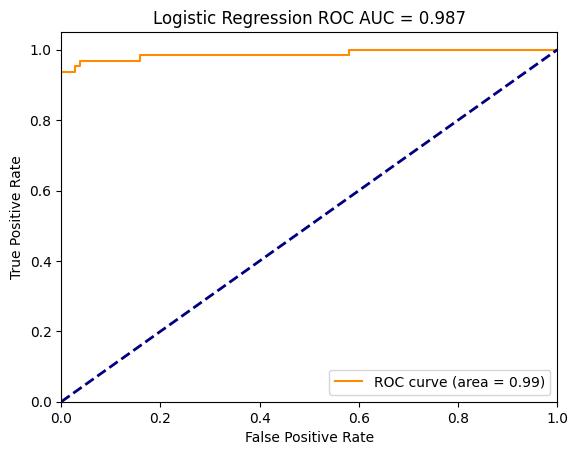

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)

roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Попробуем подобрать лучшие параметры:

In [50]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [51]:
%%time
# производим обучение по сетке
grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, pe

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]),
                         'l1_ratio': [0.25, 0.5, 0.75],
                         'max_iter': array([100, 200, 300, 400]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='roc_auc', verbose=2)

In [52]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.9959577864421729
{'C': 750.25, 'l1_ratio': 0.75, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


Воспользуемся предложением лучших параметров и посмотрим на метрики:

In [53]:
best_params = {'C': 750.25, 'l1_ratio': 0.75, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [54]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

In [55]:
print(metrics.classification_report(y_test, y_pred_gr))
print(metrics.confusion_matrix(y_test, y_pred_gr))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       107
         1.0       0.95      0.97      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

[[104   3]
 [  2  62]]


Прискорбно, что модель, в отличие от kNN продолжает говорить больным, что они не больны.

In [56]:
print('roc-auc:', metrics.roc_auc_score(y_test, y_score_gr))
print('precision:', metrics.precision_score(y_test, y_pred_gr))
print('recall:', metrics.recall_score(y_test, y_pred_gr))
print('f1:', metrics.f1_score(y_test, y_pred_gr))
print('logloss:', metrics.log_loss(y_test, y_pred_gr))

roc-auc: 0.9921144859813085
precision: 0.9538461538461539
recall: 0.96875
f1: 0.9612403100775193
logloss: 1.0539079938338352


Несмотря на то, что функция потерь уменьшилась, всё же, возвращаясь к kNN, надо отметить, что там recall выше, а это немаловажно в деле постановки диагноза.

Также стоит отметить тот факт, что обе модели не могут поставить пять диагнозов. При этом kNN говорит, что дедушка в положении, а логистическая регрессия, кроме таких заявлений, косячит более сурово.

Напоследок стоит посмотреть, какие признаки, по мнению логистической регрессии, имеют первостепенную важность.

In [57]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import shap
explainer = shap.LinearExplainer(lr_gr, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

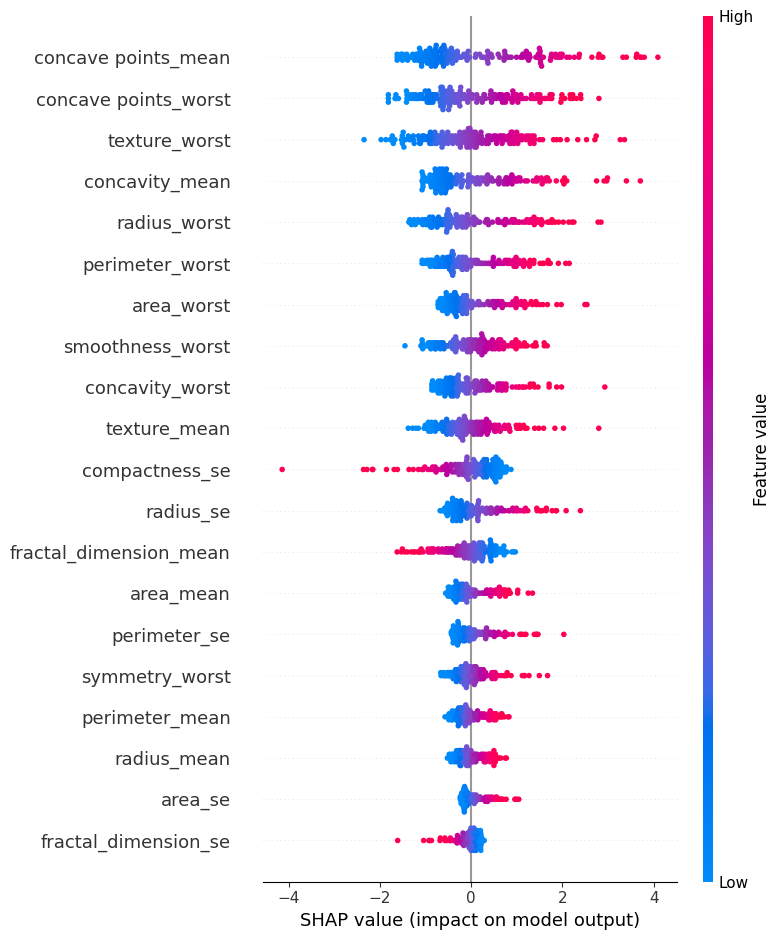

In [59]:
# summary plot
shap.summary_plot(shap_values, X_test)

Вот - полюбуйтесь: она толкует про texture и smoothness, хотя, как мы помним, для целевой переменной это не самые интересные гости. 

И очень приблизительно понимая, как это работает, мы сделаем предположение о том, что модели понравились признаки, которые менее всего коррелировали с другими.

In [60]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['imp'] = lr_gr.coef_[0]
feature_imp = feature_imp.sort_values(by='imp', ascending=False)

In [61]:
feature_imp

,feature,imp
10,radius_se,7.187115
7,concave points_mean,7.169190
21,texture_worst,6.415305
6,concavity_mean,5.439882
20,radius_worst,5.371312
12,perimeter_se,5.186570
23,area_worst,4.921162
27,concave points_worst,4.627177
24,smoothness_worst,4.452332
13,area_se,4.385549


Итог: поскольку данные касаются медицины и ошибки второго рода дорого обходятся, то, несмотря на некоторые более высокие показатели, мы отдаем предпочтение модели kNN при всем уважении к логистической регрессии. Возможно потому, что некоторые данные имеют нелинейную структуру и невнятные распределения.